In [ ]:
# !pip install mne
# !pip install tqdm

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
# df = pd.read_pickle("/content/drive/MyDrive/eeg_data/eeg_epochs_dataframe.pkl")


In [ ]:
import numpy as np

# get first row of df
# row_num = 4
# test_signal = df.iloc[row_num]
# print(type(test_signal['X']))
# print(np.array(test_signal['X']).shape)
# test_signal.head()


<class 'numpy.ndarray'>
(64, 641)


,4
subject_id,1
run,4
time_index,16
augmentation,none
X,"[[-2.0229342536218772e-05, -1.6511518229103346..."


In [ ]:
# plot eeg signals
import matplotlib.pyplot as plt

def plot_eeg_signals(eeg_data: np.ndarray, sampling_rate: float = 160):
    """
    Plots EEG signals from a numpy.ndarray.

    Args:
        eeg_data (np.ndarray): The EEG data array.
                               Expected shape: (num_channels, num_samples).
        sampling_rate (float): The sampling rate of the EEG data in Hz.
                               Defaulted to 160 Hz based on your input.
    """
    if eeg_data.ndim != 2:
      raise ValueError("eeg_data must be a 2D array")

    # gets the number of channels and samples in the eeg_signal
    num_channels, num_samples = eeg_data.shape


    time = np.arange(num_samples) / sampling_rate

    plt.figure(figsize=(10,10))

    max_amplitude = np.max(np.abs(eeg_data))

    offset_multiplier = 2.5 # multiplier for spacing
    offset_increment = max_amplitude * offset_multiplier

    for i in range(num_channels):
      # offset each channel
      offset = i * offset_increment
      plt.plot(time, eeg_data[i, :] + offset, label=f'Channel {i+1}')

    plt.xlabel('Time (Sec)')
    plt.ylabel('Amplitude (offset for clarity)')
    plt.title(f'EEG Signal Plot ({num_channels} Channels) - Sampled at {sampling_rate} Hz')

    # Set y-axis ticks and labels to represent channels
    y_tick_positions = [i * offset_increment + np.mean(eeg_data[i, :]) for i in range(num_channels)]
    plt.yticks(
        y_tick_positions,
        [f'Channel {i+1}' for i in range(num_channels)],
        rotation=0,
        fontsize=8
    )
    plt.tick_params(axis='y', length=0) # Hide y-axis ticks for cleaner look

    plt.tight_layout()
    plt.savefig('my_eeg_signal_plot_160Hz.png')
    plt.show()



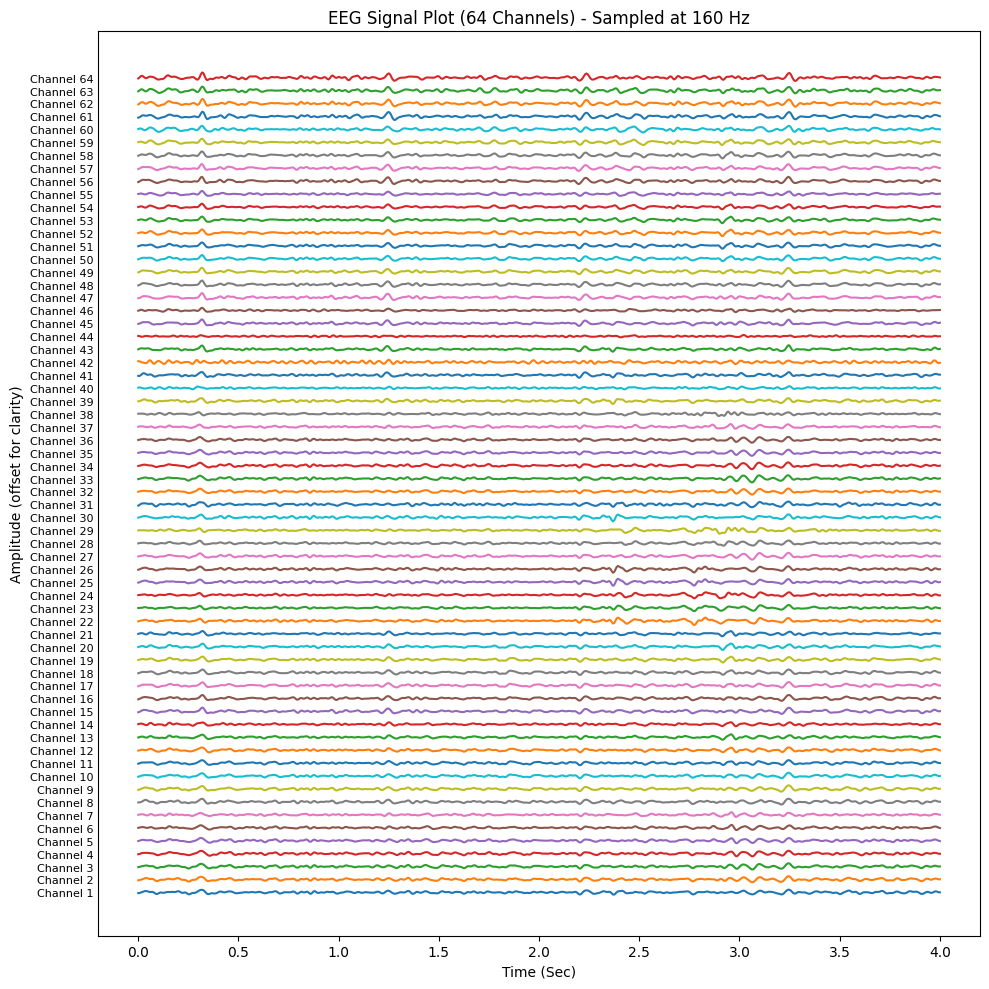

In [ ]:
# plot_eeg_signals(test_signal['X'], sampling_rate=160)

In [ ]:
def add_gaussian_noise(signal: np.ndarray, mean: float = 0.0, std_range: tuple = (0.005, 0.05), seed: int = None) -> np.ndarray:
  """
  Adds Gaussian Noise to a multi-channel EEG signal

  Parameters:
  - signal (np.ndarray): EEG data of shape (channels, time_points)
  - mean (float): Mean of Gaussian noise
  - std_range (tuple): (min_std, max_std), continuous range to sample std from
  - seed (int): allows for the addition of gaussian noise to be reproducible

  Returns:
  - np.ndarray: Signal with added Gaussian noise
  """

  if seed is not None:
    np.random.seed(seed)

  if signal.ndim != 2 or signal.shape[0] != 64:
    raise ValueError("Expected signal of shape (64, time_points)")

  std = np.random.uniform(*std_range)

  noise = np.random.normal(loc=mean, scale=std, size=signal.shape)

  return signal + noise

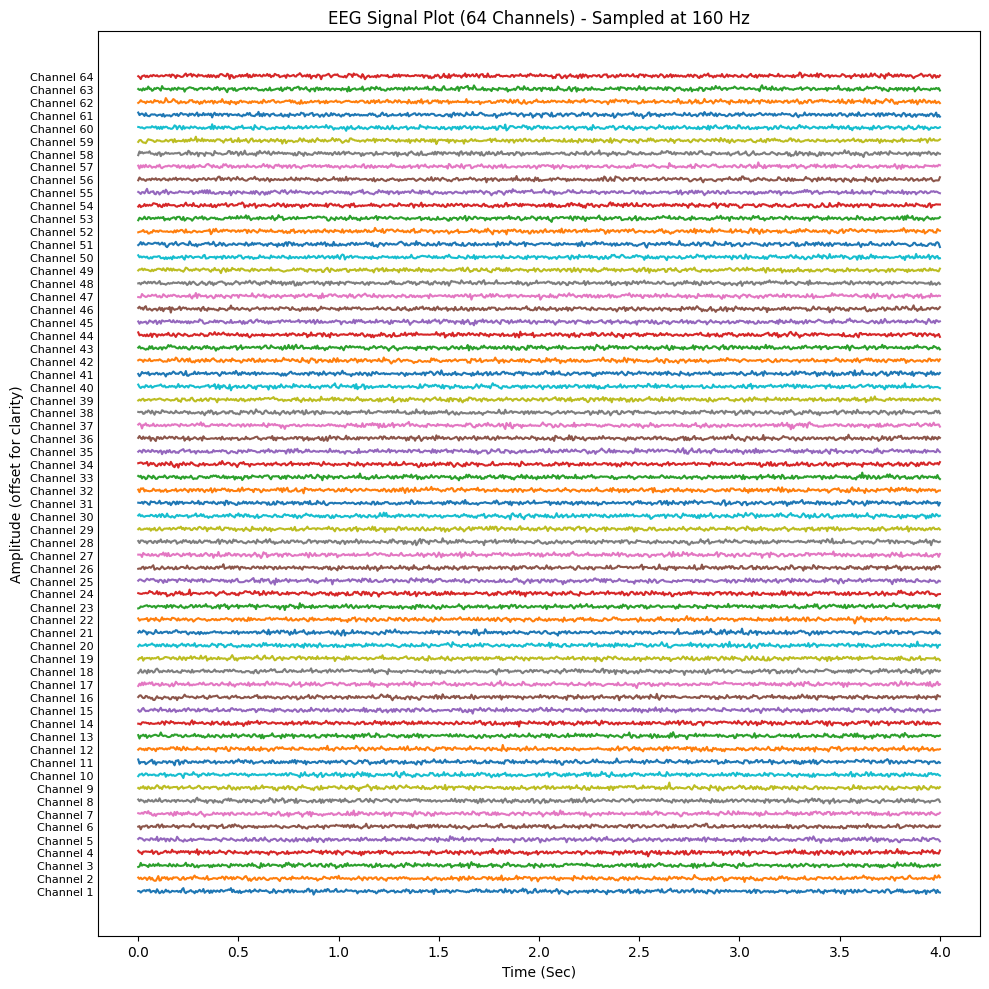

In [ ]:
# noisy_signal = add_gaussian_noise(test_signal['X'])
# plot_eeg_signals(noisy_signal, sampling_rate=160)

In [ ]:
import scipy.interpolate

def time_transformation(signal: np.ndarray, max_shift: int = 50, warp_strength: float = 0.2, seed: int = None) -> np.ndarray:
    """
    Randomly applies either time shifting (with zero padding) or time warping to a multi-channel EEG signal.

    Parameters:
    - signal (np.ndarray): EEG data of shape (channels, time_points)
    - max_shift (int): Max number of time points to shift (positive or negative)
    - warp_strength (float): Degree of time warping (0.0–0.5)
    - seed (int): Random seed for reproducibility

    Returns:
    - np.ndarray: Augmented signal with the same shape
    """

    if seed is not None:
        np.random.seed(seed)

    channels, time_points = signal.shape
    augment_type = np.random.choice(['shift', 'warp'])

    if augment_type == 'shift':
        shift = np.random.randint(-max_shift, max_shift + 1)
        augmented = np.zeros_like(signal)

        if shift > 0:
            # Shift right (later): pad beginning with 0
            augmented[:, shift:] = signal[:, :time_points - shift]
        elif shift < 0:
            # Shift left (earlier): pad end with 0
            augmented[:, :shift] = signal[:, -shift:]
        else:
            augmented = signal.copy()

    else:  # time warping
        augmented = np.zeros_like(signal)
        for ch in range(channels):
            x = np.arange(time_points)

            # Smooth, monotonic warping curve
            random_curve = np.cumsum(np.random.normal(loc=1.0, scale=warp_strength, size=time_points))
            random_curve = np.interp(x, np.linspace(0, time_points - 1, time_points), random_curve)
            random_curve = (random_curve - random_curve.min()) / (random_curve.max() - random_curve.min()) * (time_points - 1)

            # Interpolation to warp signal
            f = scipy.interpolate.interp1d(x, signal[ch], kind='linear', fill_value="extrapolate")
            augmented[ch] = f(random_curve)

    return augmented


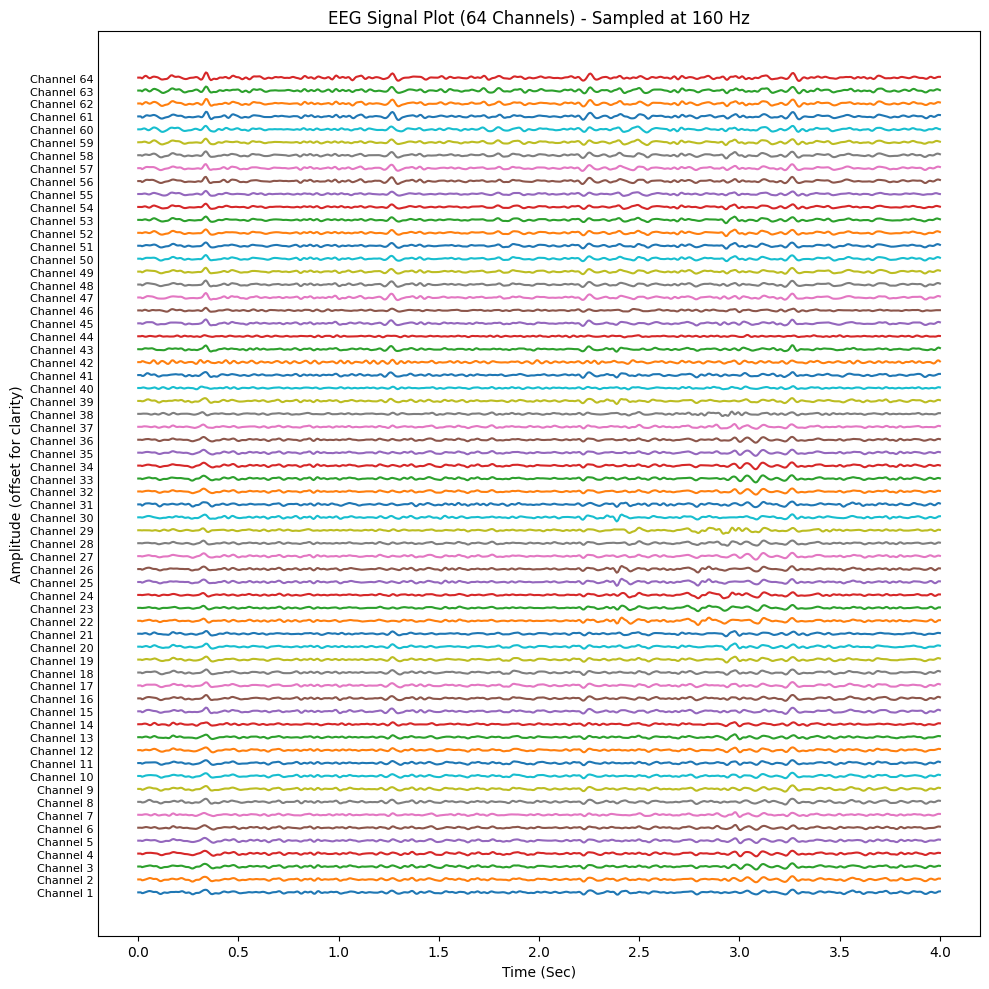

In [ ]:
# time_augmented_signal = time_transformation(test_signal['X'])
# plot_eeg_signals(time_augmented_signal, sampling_rate=160)